# BP Prediction and ABP Estimation End-to-End Pipelines

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla T4
GPU Capability: (7, 5)
Is GPU Initialized yet? True


# Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/GDrive')

Drive already mounted at /content/GDrive; to attempt to forcibly remount, call drive.mount("/content/GDrive", force_remount=True).


Move to the Target Directory

In [3]:
%cd "/content/GDrive/MyDrive/Colab_Notebooks/Research/PPG2ABP"

/content/GDrive/MyDrive/Colab_Notebooks/Research/PPG2ABP


List the Files and Folders Located in the Current Directory

In [4]:
!ls

ABP_Estimated_Fold_1.h5		    PPG2ABP_UCI.ipynb
AlbuNet_1DCNN.py		    PPG2PPG.ipynb
BCDUNet_1DCNN.py		    PPG_ECG_to_ABP_Estimation_Pipeline.ipynb
BCG_Patient_Wise_Data		    PPG_ECG_to_BP_Prediction_Pipeline.ipynb
data_handling.py		    PPGSensorData.txt
data_processing.py		    predict_test.py
delete_short_extra_est.py	    Prepare_Label.py
Dense_Inception_UNet_1DCNN.py	    Prepare_Train_Dictionary.py
evaluate.py			    __pycache__
Evaluation_Metrics_ABP.py	    Ranked_Features.h5
Evaluation_Metrics_BP.py	    ReadingSakib5.txt
Feature_Selection_Regression.ipynb  README.md
helper_functions.py		    ResNet_1DCNN.py
IBAUNet_1DCNN.py		    Res_Unet_1DCNN.py
imports_est.py			    SEDUNet_1DCNN.py
metrics.py			    Synthetic_PPG.h5
ml_models.py			    TernausNet_1DCNN.py
models_est.py			    Trained_Models
models.py			    train_models.py
NABUNet_1DCNN.py		    UCI_Dataset_Part_1_Preprocessed.h5
organize_patients_est.py	    UCI_Dataset_Part_2_Preprocessed.h5
PAVE2ABP_GitHub.ipynb		    UCI_Dataset_Part_3_

## Evaluation of Predicting ABP Waveforms

Here, we present an interactive CLI to predict the ABP waveform from PPG signal from the test data. Ground truth, prediction from approximation network and refinement network are presented, and a comparison is also demonstrated


#Import Libraries

In [5]:
import os
import h5py
import scipy
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm

In [6]:
from ml_models import *
from Evaluation_Metrics_BP import *
from Evaluation_Metrics_ABP import *
from UNet_1DCNN import UNet
from BCDUNet_1DCNN import BCDUNet
from SEDUNet_1DCNN import SEDUNet
from Dense_Inception_UNet_1DCNN import Dense_Inception_UNet
from IBAUNet_1DCNN import IBAUNet
from NABUNet_1DCNN import NABUNet

In [7]:
%matplotlib inline
sns.set_style('white')

# Set Global Constants

In [8]:
num_channel = 4
fold_num = 4

# Import and Prepare Data

Note: Data pre-processing was mainly conducted in MATLAB. Here, data was loaded from the GDrive and prepared for Deep Learning

### Import Dataset for Train and Test on UCI

In [9]:
fl_Train_1 = h5py.File(os.path.join('UCI_Dataset_Part_2_Preprocessed.h5'), 'r')
fl_Train_2 = h5py.File(os.path.join('UCI_Dataset_Part_3_Preprocessed.h5'), 'r')
fl_Train_3 = h5py.File(os.path.join('UCI_Dataset_Part_4_Preprocessed.h5'), 'r')
print(fl_Train_1['PPG'].shape)
print(fl_Train_2['PPG'].shape)
print(fl_Train_3['PPG'].shape)

(53001, 1024)
(40110, 1024)
(50646, 1024)


In [10]:
fl_Test = h5py.File(os.path.join('UCI_Dataset_Part_1_Preprocessed.h5'), 'r')  # load UCI Test Data
fl_Test['PPG'].shape

(47441, 1024)

### Prepare Train Data


In [11]:
# intialize train data
length = 1024
X_Train_All = []
Y_Train_BP_All = []
Y_Train_ABP_All = []
PPG_All = []
APG_All = []
VPG_All = []
ECG_All = []

if num_channel == 1:

    X_Train = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_1['PPG'].shape[0]), desc='Preparing Train Data Part 1'):
        X_Train.append(np.array(fl_Train_1['PPG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_1['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_1['ABP_RNorm'][i][:length]).reshape(length, 1))
    
    X_Train = np.array(X_Train)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    X_Train_All = X_Train
    Y_Train_BP_All = Y_Train_BP
    Y_Train_ABP_All = Y_Train_ABP

    X_Train = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_2['PPG'].shape[0]), desc='Preparing Train Data Part 2'):
        X_Train.append(np.array(fl_Train_2['PPG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_2['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_2['ABP_RNorm'][i][:length]).reshape(length, 1))

    X_Train = np.array(X_Train)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    X_Train_All = np.concatenate([X_Train_All, X_Train], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)
    
    X_Train = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_3['PPG'].shape[0]), desc='Preparing Train Data  Part 3'):
        X_Train.append(np.array(fl_Train_3['PPG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_3['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_3['ABP_RNorm'][i][:length]).reshape(length, 1))

    X_Train = np.array(X_Train)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    X_Train_All = np.concatenate([X_Train_All, X_Train], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)
    
    X_Train_All = np.array(X_Train_All)
    Y_Train_BP_All = np.array(Y_Train_BP_All)
    Y_Train_ABP_All = np.array(Y_Train_ABP_All)
    print(X_Train_All.shape)
    print(Y_Train_BP_All.shape)
    print(Y_Train_ABP_All.shape)

elif num_channel == 2:
    PPG = []
    ECG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_1['PPG'].shape[0]), desc='Preparing Train Data Part 1'):
        PPG.append(np.array(fl_Train_1['PPG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train_1['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_1['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_1['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    ECG = np.array(ECG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = PPG
    ECG_All = ECG
    Y_Train_BP_All = Y_Train_BP
    Y_Train_ABP_All = Y_Train_ABP

    PPG = []
    ECG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_2['PPG'].shape[0]), desc='Preparing Train Data Part 2'):
        PPG.append(np.array(fl_Train_2['PPG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train_2['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_2['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_2['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    ECG = np.array(ECG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = np.concatenate([PPG_All, PPG], axis=0)
    ECG_All = np.concatenate([ECG_All, ECG], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)

    PPG = []
    ECG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_3['PPG'].shape[0]), desc='Preparing Train Data Part 3'):
        PPG.append(np.array(fl_Train_3['PPG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train_3['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_3['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_3['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    ECG = np.array(ECG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = np.concatenate([PPG_All, PPG], axis=0)
    ECG_All = np.concatenate([ECG_All, ECG], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)

    PPG_All = np.array(PPG_All)
    ECG_All = np.array(ECG_All)
    X_Train_All = np.squeeze(np.stack((PPG_All, ECG_All), axis=2))
    Y_Train_BP_All = np.array(Y_Train_BP_All)
    Y_Train_ABP_All = np.array(Y_Train_ABP_All)
    print(X_Train_All.shape)
    print(Y_Train_BP_All.shape)
    print(Y_Train_ABP_All.shape)

elif num_channel == 3:
    PPG = []
    VPG = []
    APG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_1['PPG'].shape[0]), desc='Preparing Train Data Part 1'):
        PPG.append(np.array(fl_Train_1['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train_1['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train_1['APG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_1['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_1['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = PPG
    VPG_All = VPG
    APG_All = APG
    Y_Train_BP_All = Y_Train_BP
    Y_Train_ABP_All = Y_Train_ABP

    PPG = []
    VPG = []
    APG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_2['PPG'].shape[0]), desc='Preparing Train Data Part 2'):
        PPG.append(np.array(fl_Train_2['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train_2['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train_2['APG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_2['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_2['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = np.concatenate([PPG_All, PPG], axis=0)
    VPG_All = np.concatenate([VPG_All, VPG], axis=0)
    APG_All = np.concatenate([APG_All, APG], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)

    PPG = []
    VPG = []
    APG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_3['PPG'].shape[0]), desc='Preparing Train Data Part 3'):
        PPG.append(np.array(fl_Train_3['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train_3['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train_3['APG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_3['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_3['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = np.concatenate([PPG_All, PPG], axis=0)
    VPG_All = np.concatenate([VPG_All, VPG], axis=0)
    APG_All = np.concatenate([APG_All, APG], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)

    PPG_All = np.array(PPG_All)
    VPG_All = np.array(VPG_All)
    APG_All = np.array(APG_All)
    X_Train_All = np.squeeze(np.stack((PPG_All, VPG_All, APG_All), axis=2))
    Y_Train_BP_All = np.array(Y_Train_BP_All)
    Y_Train_ABP_All = np.array(Y_Train_ABP_All)
    print(X_Train_All.shape)
    print(Y_Train_BP_All.shape)
    print(Y_Train_ABP_All.shape)

elif num_channel == 4:
    PPG = []
    VPG = []
    APG = []
    ECG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_1['PPG'].shape[0]), desc='Preparing Train Data Part 1'):
        PPG.append(np.array(fl_Train_1['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train_1['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train_1['APG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train_1['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_1['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_1['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    ECG = np.array(ECG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = PPG
    VPG_All = VPG
    APG_All = APG
    ECG_All = ECG
    Y_Train_BP_All = Y_Train_BP
    Y_Train_ABP_All = Y_Train_ABP

    PPG = []
    VPG = []
    APG = []
    ECG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_2['PPG'].shape[0]), desc='Preparing Train Data Part 2'):
        PPG.append(np.array(fl_Train_2['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train_2['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train_2['APG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train_2['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_2['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_2['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    ECG = np.array(ECG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = np.concatenate([PPG_All, PPG], axis=0)
    VPG_All = np.concatenate([VPG_All, VPG], axis=0)
    APG_All = np.concatenate([APG_All, APG], axis=0)
    ECG_All = np.concatenate([ECG_All, ECG], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)

    PPG = []
    VPG = []
    APG = []
    ECG = []
    Y_Train_BP = []
    Y_Train_ABP = []
    for i in tqdm(range(0, fl_Train_3['PPG'].shape[0]), desc='Preparing Train Data Part 3'):
        PPG.append(np.array(fl_Train_3['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train_3['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train_3['APG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train_3['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train_3['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train_3['ABP_RNorm'][i][:length]).reshape(length, 1))

    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    ECG = np.array(ECG)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    PPG_All = np.concatenate([PPG_All, PPG], axis=0)
    VPG_All = np.concatenate([VPG_All, VPG], axis=0)
    APG_All = np.concatenate([APG_All, APG], axis=0)
    ECG_All = np.concatenate([ECG_All, ECG], axis=0)
    Y_Train_BP_All = np.concatenate([Y_Train_BP_All, Y_Train_BP], axis=0)
    Y_Train_ABP_All = np.concatenate([Y_Train_ABP_All, Y_Train_ABP], axis=0)

    PPG_All = np.array(PPG_All)
    VPG_All = np.array(VPG_All)
    APG_All = np.array(APG_All)
    ECG_All = np.array(ECG_All)
    X_Train_All = np.squeeze(np.stack((PPG_All, VPG_All, APG_All, ECG_All), axis=2))
    Y_Train_BP_All = np.array(Y_Train_BP_All)
    Y_Train_ABP_All = np.array(Y_Train_ABP_All)
    #
    print(X_Train_All.shape)
    print(Y_Train_BP_All.shape)
    print(Y_Train_ABP_All.shape)

Preparing Train Data Part 3: 100%|██████████| 50646/50646 [01:38<00:00, 512.11it/s]


(143757, 1024, 4)
(143757, 1024, 1)
(143757, 1024, 1)


### Prepare Test Data

In [12]:
# intialize test data
length = 1024
X_Test = []
Y_Test_BP = []
Y_Test_ABP = []

if num_channel == 1:

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        X_Test.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))    # ppg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    X_Test = np.array(X_Test)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 2:
    PPG = []
    ECG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        ECG.append(np.array(fl_Test['ECG'][i][:length]).reshape(length, 1))       # ecg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    ECG = np.array(ECG)
    X_Test = np.stack((PPG, ECG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 3:
    PPG = []
    VPG = []
    APG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        VPG.append(np.array(fl_Test['VPG'][i][:length]).reshape(length, 1))       # vpg signal
        APG.append(np.array(fl_Test['APG'][i][:length]).reshape(length, 1))       # apg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    X_Test = np.stack((PPG, VPG, APG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 4:
    PPG = []
    VPG = []
    APG = []
    ECG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        VPG.append(np.array(fl_Test['VPG'][i][:length]).reshape(length, 1))       # vpg signal
        APG.append(np.array(fl_Test['APG'][i][:length]).reshape(length, 1))       # apg signal
        ECG.append(np.array(fl_Test['ECG'][i][:length]).reshape(length, 1))       # apg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    ECG = np.array(ECG)
    X_Test = np.stack((PPG, VPG, APG, ECG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape
    #
    print(X_Test.shape)
    print(Y_Test_BP.shape)
    print(Y_Test_ABP.shape)

Preparing Test Data: 100%|██████████| 47441/47441 [01:35<00:00, 496.44it/s]


(47441, 1024, 4, 1)
(47441, 1024, 1)
(47441, 1024, 1)


### Extract SBP and DBP Label Data from the Training Set

In [13]:
SBP_Train_1 = []
SBP_Train_2 = []
SBP_Train_3 = []
DBP_Train_1 = []
DBP_Train_2 = []
DBP_Train_3 = []

# SBP
for i in tqdm(range(0, fl_Train_1['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Train Data Part 1'):
    SBP_Train_1.append(np.array(fl_Train_1['SBP'][i][0]).reshape(1, 1)) 
SBP_Train_1 = np.squeeze(np.array(SBP_Train_1), axis=2)

for i in tqdm(range(0, fl_Train_2['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Train Data Part 2'):
    SBP_Train_2.append(np.array(fl_Train_2['SBP'][i][0]).reshape(1, 1)) 
SBP_Train_2 = np.squeeze(np.array(SBP_Train_2), axis=2)

for i in tqdm(range(0, fl_Train_3['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Train Data Part 3'):
    SBP_Train_3.append(np.array(fl_Train_3['SBP'][i][0]).reshape(1, 1)) 
SBP_Train_3 = np.squeeze(np.array(SBP_Train_3), axis=2)

SBP_Train = np.squeeze(np.concatenate((SBP_Train_1, SBP_Train_2, SBP_Train_3), axis=0))
print(SBP_Train.shape)

# DBP
for i in tqdm(range(0, fl_Train_1['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Train Data Part 1'):
    DBP_Train_1.append(np.array(fl_Train_1['DBP'][i][0]).reshape(1, 1)) 
DBP_Train_1 = np.squeeze(np.array(DBP_Train_1), axis=2)

for i in tqdm(range(0, fl_Train_2['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Train Data Part 2'):
    DBP_Train_2.append(np.array(fl_Train_2['DBP'][i][0]).reshape(1, 1)) 
DBP_Train_2 = np.squeeze(np.array(DBP_Train_2), axis=2)

for i in tqdm(range(0, fl_Train_3['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Train Data Part 3'):
    DBP_Train_3.append(np.array(fl_Train_3['DBP'][i][0]).reshape(1, 1)) 
DBP_Train_3 = np.squeeze(np.array(DBP_Train_3), axis=2)

DBP_Train = np.squeeze(np.concatenate((DBP_Train_1, DBP_Train_2, DBP_Train_3), axis=0))
#
print(DBP_Train.shape)

Extracting Ground_Truth SBP from Train Data Part 1: 100%|██████████| 53001/53001 [00:15<00:00, 3331.57it/s]
Extracting Ground_Truth SBP from Train Data Part 2: 100%|██████████| 40110/40110 [00:11<00:00, 3388.68it/s]
Extracting Ground_Truth SBP from Train Data Part 3: 100%|██████████| 50646/50646 [00:14<00:00, 3390.71it/s]


(143757,)


Extracting Ground_Truth DBP from Train Data Part 1: 100%|██████████| 53001/53001 [00:15<00:00, 3385.93it/s]
Extracting Ground_Truth DBP from Train Data Part 2: 100%|██████████| 40110/40110 [00:11<00:00, 3396.57it/s]
Extracting Ground_Truth DBP from Train Data Part 3: 100%|██████████| 50646/50646 [00:14<00:00, 3391.53it/s]


(143757,)


### Extract Ground Truth SBP and DBP from the Testing Set

In [14]:
SBP_Test = []
DBP_Test = []

# SBP
for i in tqdm(range(0, fl_Test['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Testing Set'):
    SBP_Test.append(np.array(fl_Test['SBP'][i][0]).reshape(1, 1)) 

SBP_Test = np.squeeze(np.array(SBP_Test),axis=2)

# DBP
for i in tqdm(range(0, fl_Test['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Testing Set'):
    DBP_Test.append(np.array(fl_Test['DBP'][i][0]).reshape(1, 1)) 

DBP_Test = np.squeeze(np.array(DBP_Test),axis=2)
#
print(SBP_Test.shape)
print(DBP_Test.shape)

Extracting Ground_Truth DBP from Testing Set: 100%|██████████| 47441/47441 [00:13<00:00, 3410.96it/s]

(47441, 1)
(47441, 1)


### Prepare ABP Ground Truth for PPG2ABP

In [15]:
ABP_GRND = []

for i in tqdm(range(0, fl_Test['ABP_GRND'].shape[0]), desc='Extracting Ground_Truth'):
    ABP_GRND.append(np.array(fl_Test['ABP_GRND'][i][:length]).reshape(length, 1)) 

ABP_GRND = np.array(ABP_GRND)
ABP_GRND.shape

Extracting Ground_Truth: 100%|██████████| 53001/53001 [00:18<00:00, 2816.98it/s]


(53001, 1024, 1)

### Train-Val Split [Test Data is Completely Independent]

In [15]:
X_Train1, X_Val1, Y_Train1, Y_Val1, Y_Train2, Y_Val2, SBP_Train1, SBP_Val1, DBP_Train1, DBP_Val1 = train_test_split(X_Train_All, Y_Train_BP_All, Y_Train_ABP_All, SBP_Train, DBP_Train, test_size=0.2, random_state=42)

In [16]:
X_Test1 = X_Test
Y_Test1 = Y_Test_BP
Y_Test2 = Y_Test_ABP

### Save Splitted UCI Dataset

In [ ]:
if num_channel == 1:
  hf = h5py.File('UCI_Splitted_Data_1CH.h5', 'w')

elif num_channel == 2:
  hf = h5py.File('UCI_Splitted_Data_2CH.h5', 'w')

elif num_channel == 3:
  hf = h5py.File('UCI_Splitted_Data_3CH.h5', 'w')

elif num_channel == 4:
  hf = h5py.File('UCI_Splitted_Data_4CH.h5', 'w')
#
hf.create_dataset('X_Train1', data=X_Train1)
hf.create_dataset('X_Val1', data=X_Val1)
hf.create_dataset('Y_Train1', data=Y_Train1)
hf.create_dataset('Y_Val1', data=Y_Val1)
hf.create_dataset('Y_Train2', data=Y_Train2)
hf.create_dataset('Y_Val2', data=Y_Val2)
hf.create_dataset('X_Test1', data=X_Test1)
hf.create_dataset('Y_Test1', data=Y_Test1)
hf.create_dataset('Y_Test2', data=Y_Test2)
hf.create_dataset('SBP_Train1', data=SBP_Train1)
hf.create_dataset('SBP_Val1', data=SBP_Val1)
hf.create_dataset('DBP_Train1', data=DBP_Train1)
hf.create_dataset('DBP_Val1', data=DBP_Val1)
hf.create_dataset('SBP_Test', data=SBP_Test)
hf.create_dataset('DBP_Test', data=DBP_Test)
hf.create_dataset('ABP_GRND', data=ABP_GRND)
#
hf.close()

### Import Splitted UCI Dataset

In [ ]:
if num_channel == 1:
  hf = h5py.File('UCI_Splitted_Data_1CH.h5', 'r')
  hf.keys()

elif num_channel == 2:
  hf = h5py.File('UCI_Splitted_Data_2CH.h5', 'r')
  hf.keys()

elif num_channel == 3:
  hf = h5py.File('UCI_Splitted_Data_3CH.h5', 'r')
  hf.keys()

elif num_channel == 4:
  hf = h5py.File('UCI_Splitted_Data_4CH.h5', 'r')
  hf.keys()

In [ ]:
X_Train1 = np.array(hf.get('X_Train1'))
X_Val1 = np.array(hf.get('X_Val1'))
Y_Train1 = np.array(hf.get('Y_Train1'))
Y_Val1 = np.array(hf.get('Y_Val1'))
Y_Train2 = np.array(hf.get('Y_Train2'))
Y_Val2 = np.array(hf.get('Y_Val2'))
SBP_Train1 = np.array(hf.get('SBP_Train1'))
SBP_Val1 = np.array(hf.get('SBP_Val1'))
DBP_Train1 = np.array(hf.get('DBP_Train1'))
DBP_Val1 = np.array(hf.get('DBP_Val1'))
SBP_Test = np.array(hf.get('SBP_Test'))
DBP_Test = np.array(hf.get('DBP_Test'))
ABP_GRND = np.array(hf.get('ABP_GRND'))
X_Test1 = np.array(hf.get('X_Test1'))
Y_Test1 = np.array(hf.get('Y_Test1'))
Y_Test2 = np.array(hf.get('Y_Test2'))

### Garbage Collector

In [17]:
import gc #Garbage Collector
PPG = None
VPG = None
APG = None
ECG = None
PPG_All = None
VPG_All = None
APG_All = None
ECG_All = None
X_Train_All = None
Y_Train_BP_All = None
Y_Train_ABP_All = None
fl_Train = None
fl_Test = None
X_Test = None
SBP_Train_1 = None
SBP_Train_2 = None
SBP_Train_3 = None
DBP_Train_1 = None
DBP_Train_2 = None
DBP_Train_3 = None
SBP_Train = None
DBP_Train = None
gc.collect()

70

# BP Prediction

## Build and Train Autoencoder

Configurations

In [18]:
# Configurations
feature_number = 1024
signal_length = 1024
PPG2BP_model_depth = 1
PPG2BP_model_width = 64
kernel_size_PPG2BP = 3
D_S = 0
A_E = 1
A_G = 0
LSTM = 0
alpha = 1
model_name = 'UNet'

In [19]:
# Build model for PPG2BP - Shallow-Wide U-Net as AutoEncoder
PAVE2BP_Network = UNet(signal_length, PPG2BP_model_depth, num_channel, PPG2BP_model_width, kernel_size_PPG2BP, 'Regression', 1, 
                       D_S, A_E, A_G, LSTM, alpha, feature_number).UNet()
PAVE2BP_Network.compile(optimizer='adam', loss='mse', metrics=['mse', 'accuracy'])

In [ ]:
PAVE2BP_Network.load_weights('Trained_Models/PAVE2BP_UCI_'+model_name+'_'+str(PPG2BP_model_depth)+'_'+str(PPG2BP_model_width)+'_'+str(kernel_size_PPG2BP)+'_'+str(num_channel)+'_Fold_'+str(fold_num)+'.h5')

In [20]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min'), 
             tf.keras.callbacks.ModelCheckpoint('Trained_Models/PAVE2BP_UCI_'+model_name+'_'+str(PPG2BP_model_depth)+'_'
             +str(PPG2BP_model_width)+'_'+str(kernel_size_PPG2BP)+'_'+str(num_channel)+'_Fold_'+str(fold_num)+'.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = PAVE2BP_Network.fit(X_Train1, Y_Train1, epochs= 100, batch_size= 128, verbose=1, validation_data= (X_Val1, Y_Val2), shuffle= True, callbacks= callbacks)

Epoch 1/100
899/899 [==============================] - ETA: 0s - loss: 0.0201 - mse: 0.0201 - accuracy: 3.3966e-08
Epoch 1: val_loss improved from inf to 0.05079, saving model to Trained_Models/PAVE2BP_UCI_UNet_1_64_3_4_Fold_4.h5
899/899 [==============================] - 115s 116ms/step - loss: 0.0201 - mse: 0.0201 - accuracy: 3.3966e-08 - val_loss: 0.0508 - val_mse: 0.0508 - val_accuracy: 0.0012
Epoch 2/100
899/899 [==============================] - ETA: 0s - loss: 0.0109 - mse: 0.0109 - accuracy: 5.0949e-08
Epoch 2: val_loss did not improve from 0.05079
899/899 [==============================] - 104s 115ms/step - loss: 0.0109 - mse: 0.0109 - accuracy: 5.0949e-08 - val_loss: 0.0603 - val_mse: 0.0603 - val_accuracy: 9.7065e-04
Epoch 3/100
899/899 [==============================] - ETA: 0s - loss: 0.0095 - mse: 0.0095 - accuracy: 5.0949e-08
Epoch 3: val_loss improved from 0.05079 to 0.04697, saving model to Trained_Models/PAVE2BP_UCI_UNet_1_64_3_4_Fold_4.h5
899/899 [===================

Plot History

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


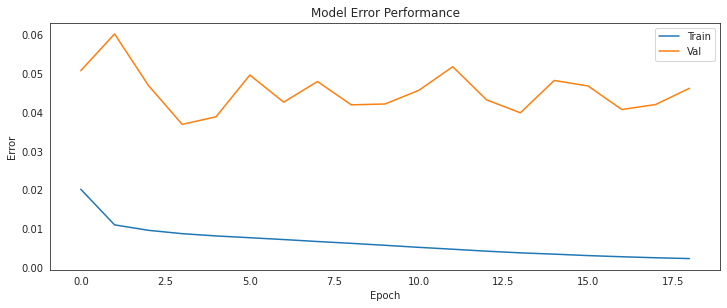

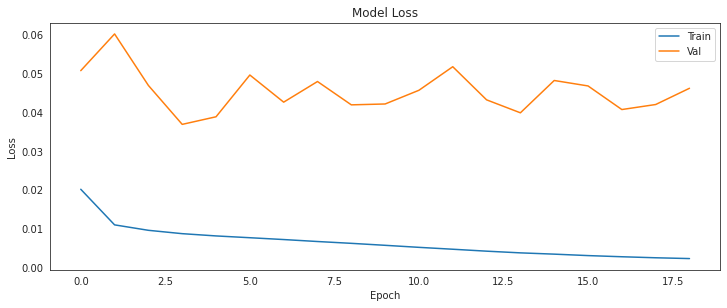

In [21]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Extract Features from the Autoencoder

In [22]:
Feature_Extractor = tf.keras.Model(inputs = PAVE2BP_Network.input, outputs = PAVE2BP_Network.get_layer('features').output)

if num_channel == 1:
  Y_Train1_1x = Y_Train1
  Y_Test1_1x = Y_Test1
  Train_Features = Feature_Extractor.predict(Y_Train1_1x)
  Test_Features = Feature_Extractor.predict(Y_Test1_1x)

elif num_channel == 2:
  Y_Train1_2x = np.array(tf.keras.layers.concatenate([Y_Train1,Y_Train1]))
  Y_Test1_2x = np.array(tf.keras.layers.concatenate([Y_Test1,Y_Test1]))
  Train_Features = Feature_Extractor.predict(Y_Train1_2x)
  Test_Features = Feature_Extractor.predict(Y_Test1_2x)

elif num_channel == 3:
  Y_Train1_3x = np.array(tf.keras.layers.concatenate([Y_Train1,Y_Train1,Y_Train1]))
  Y_Test1_3x = np.array(tf.keras.layers.concatenate([Y_Test1,Y_Test1,Y_Test1]))
  Train_Features = Feature_Extractor.predict(Y_Train1_3x)
  Test_Features = Feature_Extractor.predict(Y_Test1_3x)

elif num_channel == 4:
  Y_Train1_4x = np.array(tf.keras.layers.concatenate([Y_Train1,Y_Train1,Y_Train1,Y_Train1]))
  Y_Test1_4x = np.array(tf.keras.layers.concatenate([Y_Test1,Y_Test1,Y_Test1,Y_Test1]))
  Train_Features = Feature_Extractor.predict(Y_Train1_4x)
  Test_Features = Feature_Extractor.predict(Y_Test1_4x)

In [ ]:
Feature_Extractor = tf.keras.Model(inputs = PAVE2BP_Network.input, outputs = PAVE2BP_Network.get_layer('features').output)
Train_Features = Feature_Extractor.predict(X_Train1)
Test_Features = Feature_Extractor.predict(X_Test1)

Save Feature Matrices

In [23]:
outfile = open('Trained_Models/Train_Features_PAVE2BP_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','wb')
pickle.dump(Train_Features, outfile)
outfile.close()
#
outfile = open('Trained_Models/Test_Features_PAVE2BP_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','wb')
pickle.dump(Test_Features, outfile)
outfile.close()

In [24]:
print(Train_Features.shape)
print(Test_Features.shape)

(115005, 1024)
(47441, 1024)


Import Saved Features

In [25]:
infile = open('Trained_Models/Train_Features_PAVE2BP_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','rb')
Train_Features = pickle.load(infile)
infile.close()
#
infile = open('Trained_Models/Test_Features_PAVE2BP_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','rb')
Test_Features = pickle.load(infile)
infile.close()

## Regression on Extracted Features

In [26]:
# Prediction from ML Algorithm
[Preds_SBP_PAVE2BP, Score_SBP_PAVE2BP] = mlp_regressor(Train_Features, Test_Features, SBP_Train1)
[Preds_DBP_PAVE2BP, Score_DBP_PAVE2BP] = mlp_regressor(Train_Features, Test_Features, DBP_Train1)
# Preds_SBP_PAVE2BP = Ensemble(Train_Features_2, Test_Features_2, SBP_Train).random_forest_regressor()
# Preds_DBP_PAVE2BP = Ensemble(Train_Features_2, Test_Features_2, DBP_Train).random_forest_regressor()

In [27]:
outfile = open('Trained_Models/Preds_SBP_Channel_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','wb')
pickle.dump(Preds_SBP_PAVE2BP, outfile)
outfile.close()
#
outfile = open('Trained_Models/Preds_DBP_Channel_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','wb')
pickle.dump(Preds_DBP_PAVE2BP, outfile)
outfile.close()

In [28]:
infile = open('Trained_Models/Preds_SBP_Channel_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','rb')
Preds_SBP_PAVE2BP = pickle.load(infile)
infile.close()
#
infile = open('Trained_Models/Preds_DBP_Channel_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','rb')
Preds_DBP_PAVE2BP = pickle.load(infile)
infile.close()

## Evaluate BP Prediction

MAE - MSE - RMSE - PCC

In [29]:
from scipy.stats import pearsonr
def Construction_Error(GRND, Pred):
    mae_construction_err = []
    mse_construction_err = []
    rmse_construction_err = []
    cc = []
    bad_indices = []
    count = 0

    for i in range(len(GRND)):

        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        MSE = mean_squared_error(Pred[i].ravel(), GRND[i].ravel(), squared=True)
        RMSE = mean_squared_error(Pred[i].ravel(), GRND[i].ravel(), squared=False)

        if ~(np.std(Pred[i].ravel())==0 or np.std(GRND[i].ravel())==0):
          corr, _ = pearsonr(Pred[i].ravel(), GRND[i].ravel())
        else:
          continue
        
        if MAE < 1:
            mae_construction_err.append(MAE)
            mse_construction_err.append(MSE)
            rmse_construction_err.append(RMSE)
            cc.append(corr)
        elif MAE >= 1:
            count = count + 1
            bad_indices.append(i)

    print(f'MAE Construction Error : {round(np.mean(mae_construction_err), 3)} +/- {round(np.std(mae_construction_err), 3)}')
    print(f'MSE Construction Error : {round(np.mean(mse_construction_err), 3)} +/- {round(np.std(mse_construction_err), 3)}')
    print(f'RMSE Construction Error : {round(np.mean(rmse_construction_err), 3)} +/- {round(np.std(rmse_construction_err), 3)}')
    print(f'Pearson Correlation : {round(np.mean(cc)*100, 3)}% +/- {round(np.std(cc)*100, 3)}')
    print(f'Number of Bad Predictions = {count}')

In [30]:
Construction_Error(SBP_Test, Preds_SBP_PAVE2BP)

MAE Construction Error : nan +/- nan
MSE Construction Error : nan +/- nan
RMSE Construction Error : nan +/- nan
Pearson Correlation : nan% +/- nan
Number of Bad Predictions = 0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
Construction_Error(DBP_Test, Preds_DBP_PAVE2BP)

MAE Construction Error : nan +/- nan
MSE Construction Error : nan +/- nan
RMSE Construction Error : nan +/- nan
Pearson Correlation : nan% +/- nan
Number of Bad Predictions = 0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BHS

------------------------------------------
|        BHS-Metric-BP Prediction        |
------------------------------------------
------------------------------------------
|       | <= 5mmHg | <=10mmHg | <=15mmHg |
------------------------------------------
|  DBP  |   98.58 %   |   99.97 %   |  100.0 %    |
|  SBP  |   77.35 %   |   97.13 %   |  99.74 %    |
------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


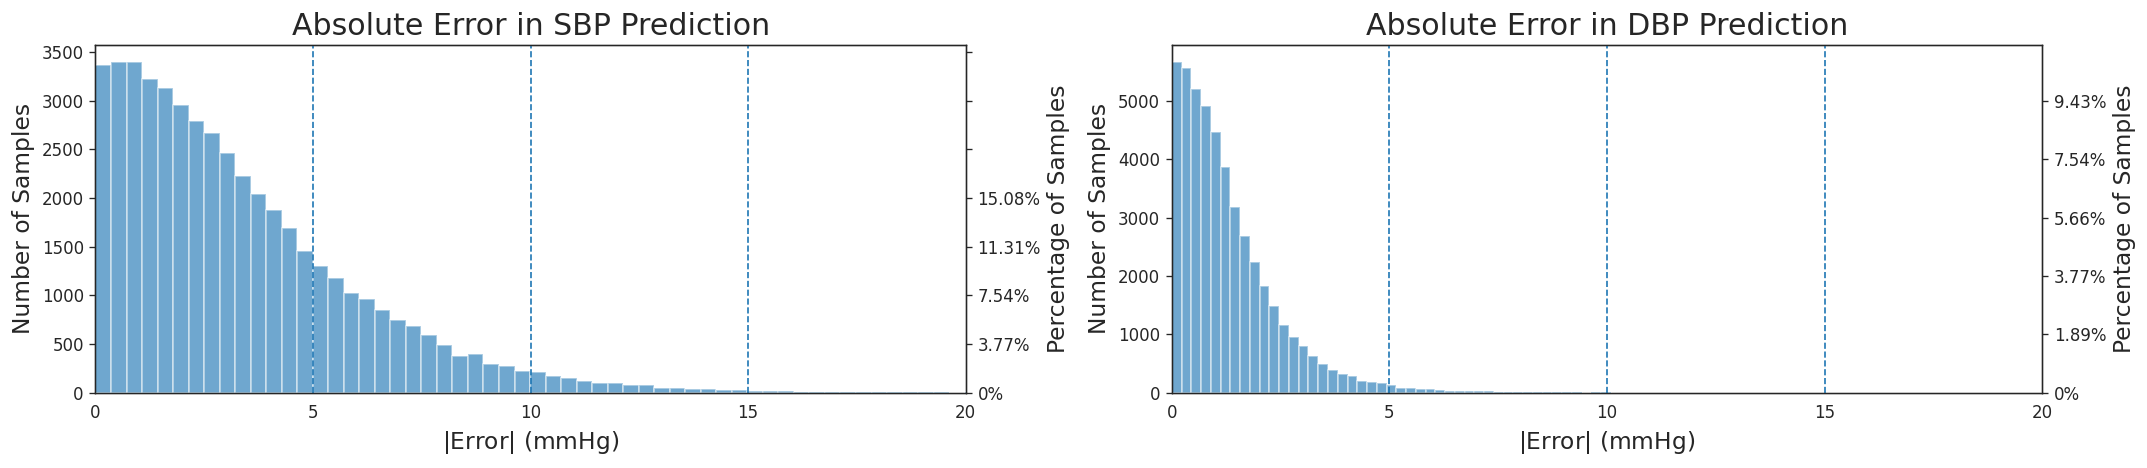

In [32]:
BHS_Metric_BP(SBP_Test, Preds_SBP_PAVE2BP, DBP_Test, Preds_DBP_PAVE2BP)

AAMI

---------------------------------
| AAMI Standard - BP_Prediction |
---------------------------------
-----------------------
|     | ME | STD |     
-----------------------
| DBP | -0.585 |  1.656 |
| SBP | -1.769 |  3.971 |
-----------------------


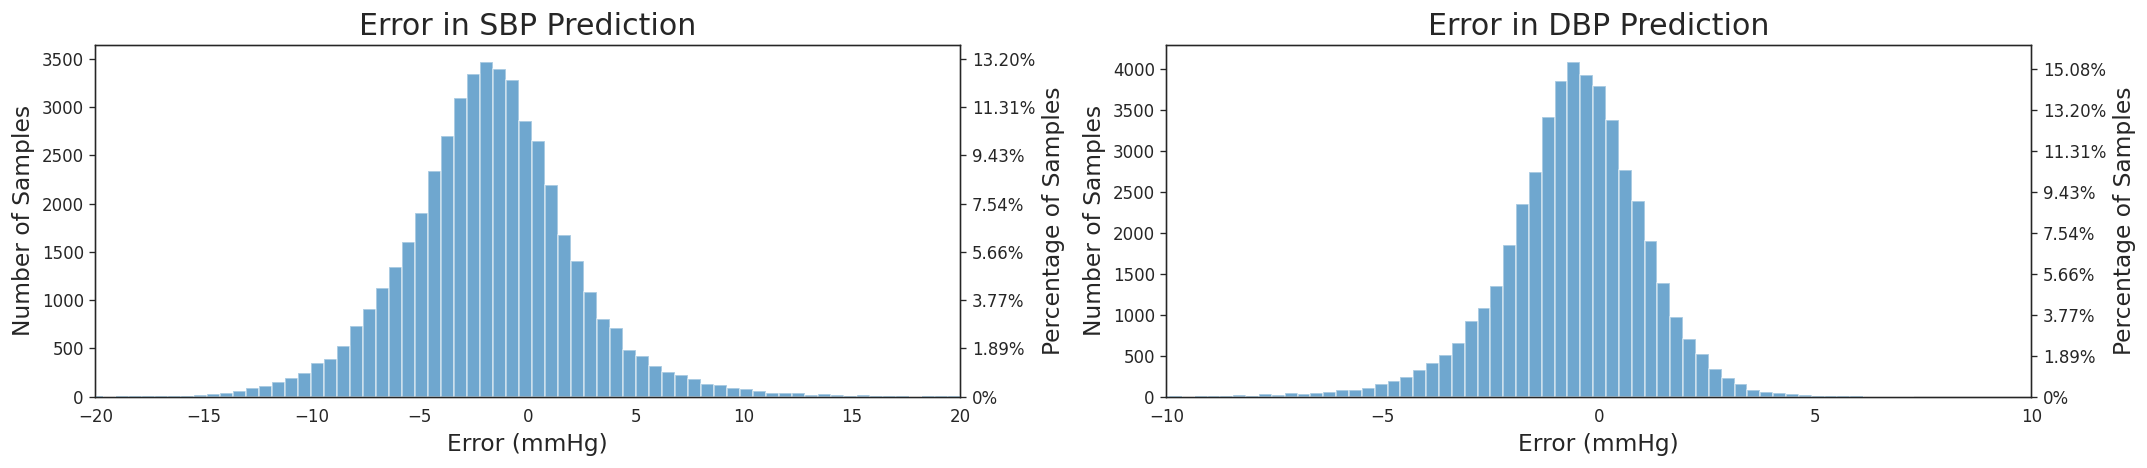

In [33]:
calcErrorAAMI_BP(SBP_Test, Preds_SBP_PAVE2BP, DBP_Test, Preds_DBP_PAVE2BP)

BP Classificaiton

DBP Classification Accuracy
                  precision    recall  f1-score   support

    Hypertension    0.88060   0.92809   0.90372       890
    Normotension    0.99613   0.99134   0.99373     44358
Pre-hypertension    0.81043   0.87141   0.83982      2193

        accuracy                        0.98461     47441
       macro avg    0.89572   0.93028   0.91242     47441
    weighted avg    0.98538   0.98461   0.98493     47441

SBP Classification Accuracy
                 precision    recall  f1-score   support

   Hypertension    0.93134   0.97628   0.95328     20535
   Normotension    0.94522   0.92183   0.93338     12486
Prehypertension    0.89380   0.85153   0.87215     14420

       accuracy                        0.92403     47441
      macro avg    0.92345   0.91655   0.91960     47441
   weighted avg    0.92358   0.92403   0.92338     47441



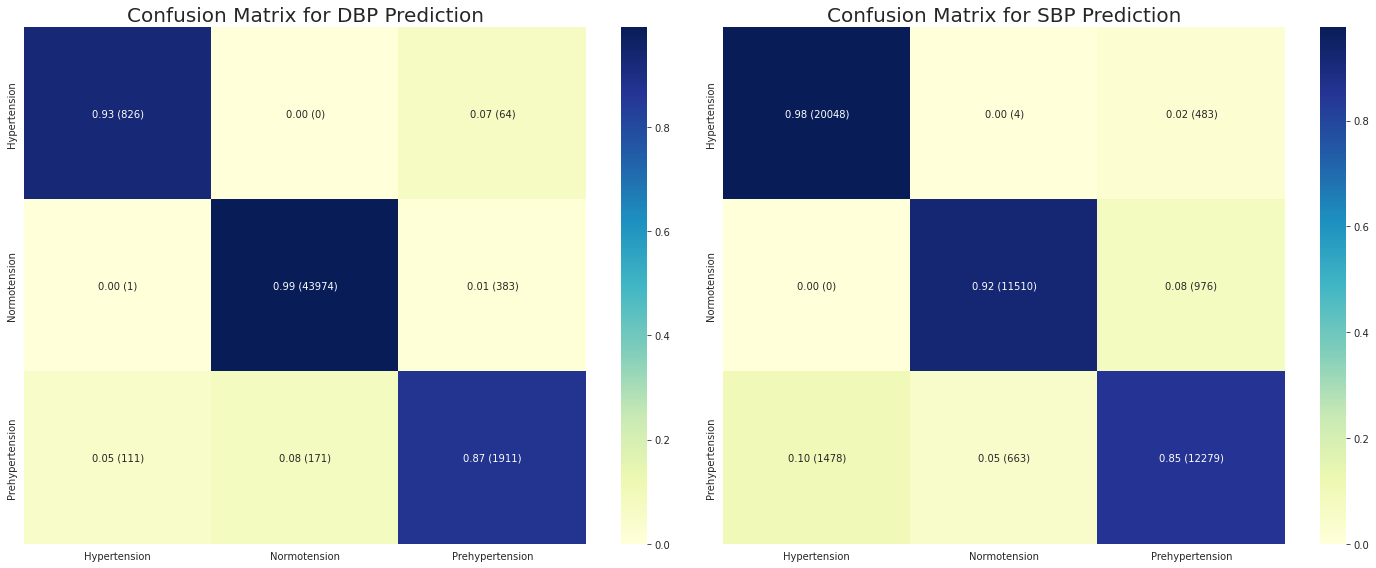

In [34]:
evaluate_BP_Classification_BP(SBP_Test, DBP_Test, Preds_SBP_PAVE2BP, Preds_DBP_PAVE2BP)

Regression Plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


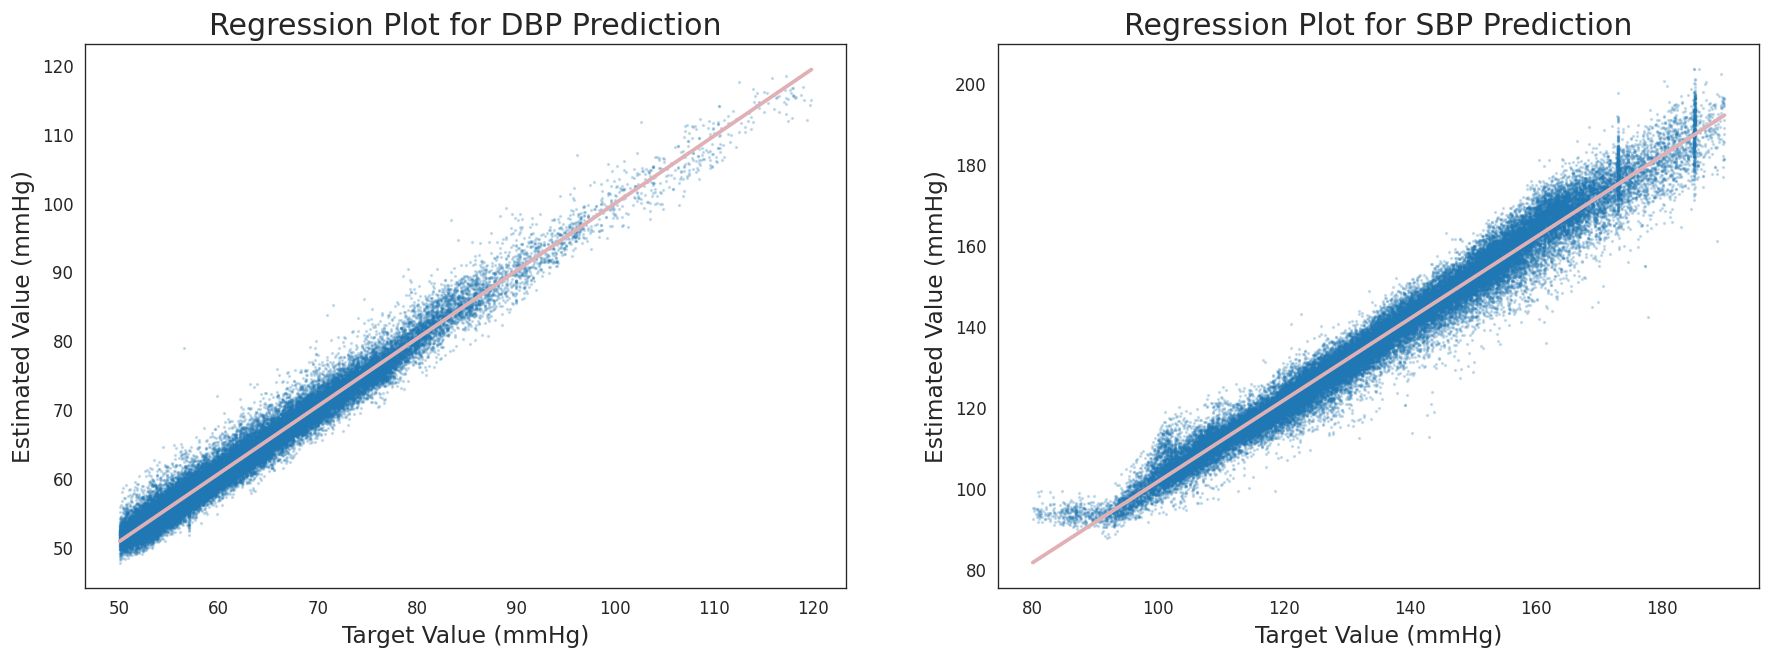

DBP
LinregressResult(slope=0.9809998635005428, intercept=1.7855233684634086, rvalue=0.986261836254389, pvalue=0.0, stderr=0.0007543824027247665, intercept_stderr=0.0482462660452828)
SBP
LinregressResult(slope=1.0056150299823419, intercept=1.005683781995458, rvalue=0.9845198846910678, pvalue=0.0, stderr=0.0008219668898892106, intercept_stderr=0.11323273589443454)


In [35]:
regression_plot_BP(SBP_Test, DBP_Test, Preds_SBP_PAVE2BP, Preds_DBP_PAVE2BP)

Bland Altman Plots

---------DBP---------
2.660893046502035 -3.8316214359185112
---------SBP---------
6.014518080780689 -9.552742376350572


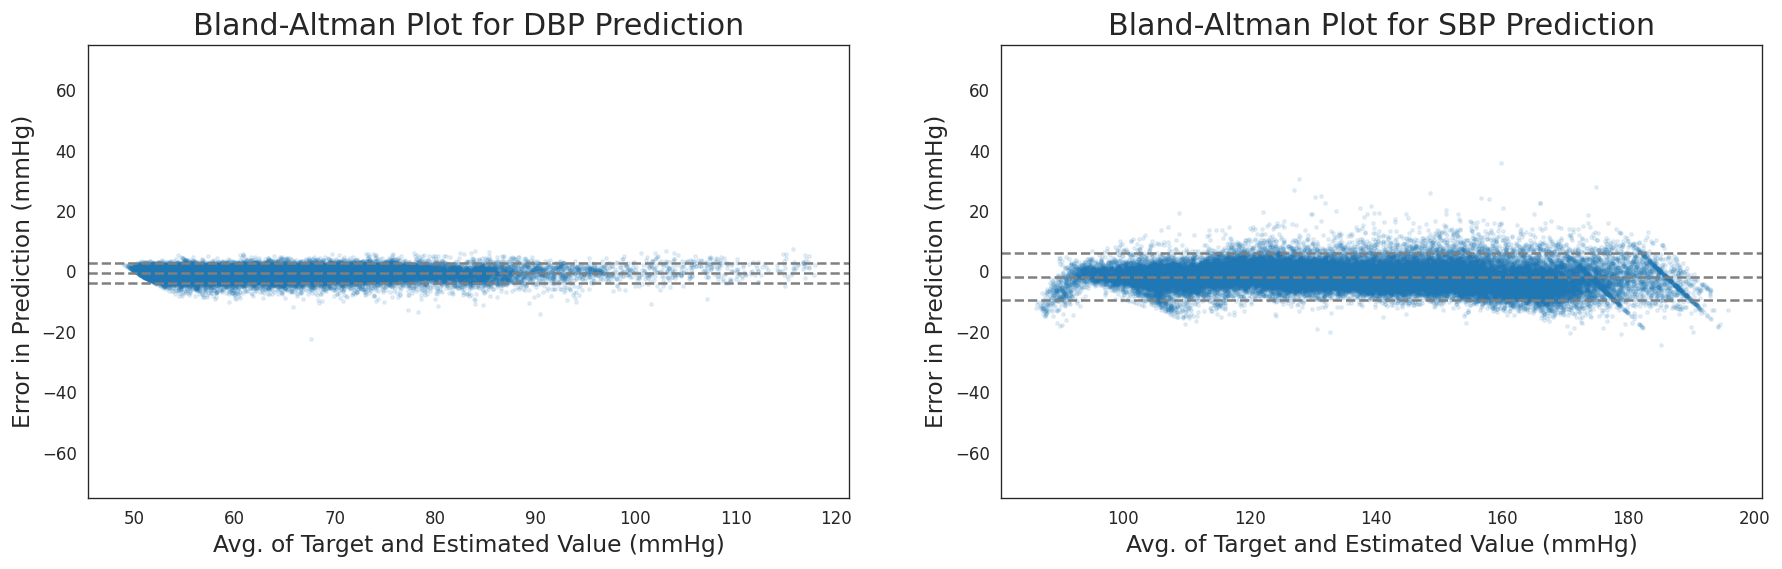

In [36]:
bland_altman_plot_BP(SBP_Test, DBP_Test, Preds_SBP_PAVE2BP, Preds_DBP_PAVE2BP)

Text(0, 0.5, 'Density')

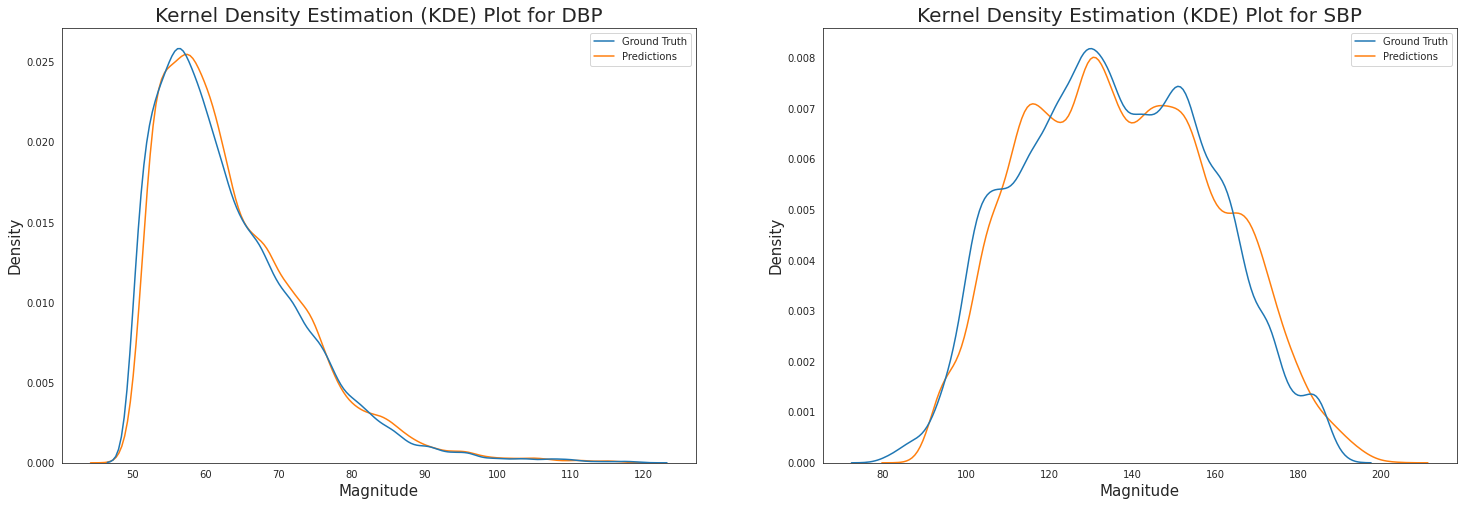

In [37]:
df_DBP = pd.DataFrame(data = {'Ground Truth': DBP_Test.ravel(), 'Predictions': Preds_DBP_PAVE2BP.ravel()})
df_SBP = pd.DataFrame(data = {'Ground Truth': SBP_Test.ravel(), 'Predictions': Preds_SBP_PAVE2BP.ravel()})
plt.figure(figsize=(25,8))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_DBP)
plt.title('Kernel Density Estimation (KDE) Plot for DBP', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_SBP)
plt.title('Kernel Density Estimation (KDE) Plot for SBP', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Text(0, 0.5, 'Magnitude')

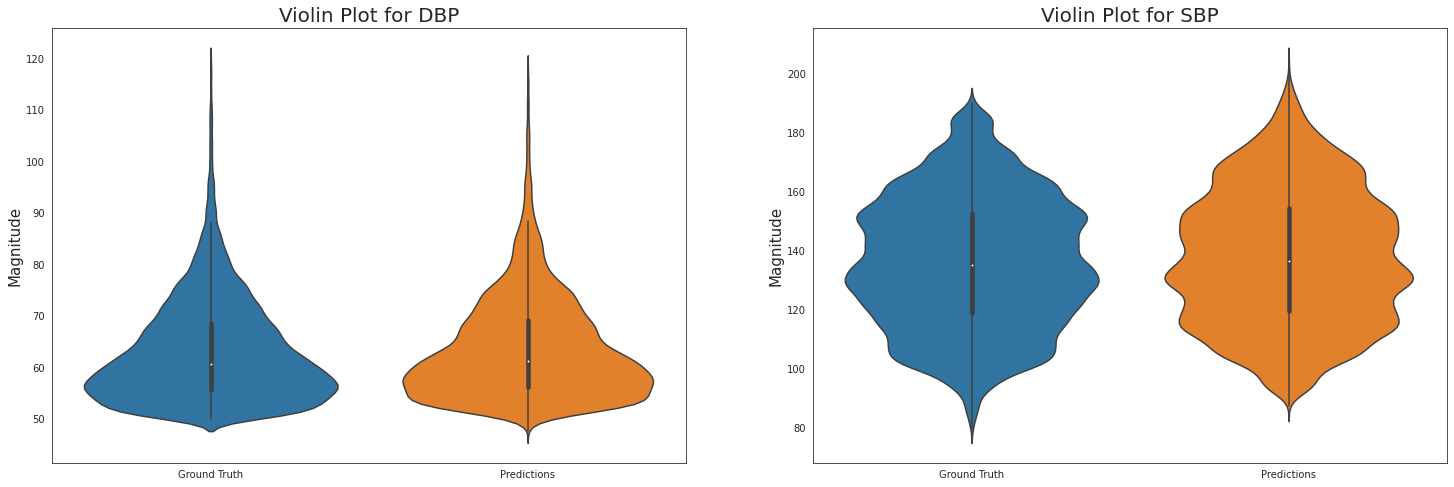

In [38]:
df_DBP = pd.DataFrame(data = {'Ground Truth': DBP_Test.ravel(), 'Predictions': Preds_DBP_PAVE2BP.ravel()})
df_SBP = pd.DataFrame(data = {'Ground Truth': SBP_Test.ravel(), 'Predictions': Preds_SBP_PAVE2BP.ravel()})
plt.figure(figsize=(25,8))
plt.subplot(1, 2, 1)
sns.violinplot(data=df_DBP)
plt.title('Violin Plot for DBP', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)
plt.subplot(1, 2, 2)
sns.violinplot(data=df_SBP)
plt.title('Violin Plot for SBP', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

# ABP Estimation

Configurations

In [ ]:
# Configurations
signal_length = 1024  # Length of each Segment
model_depth = 5  # Number of Level in the CNN Model
model_width = 64  # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3  # Size of the Kernels/Filter
num_channel = 4  # Number of Channels in the Model
D_S = 0  # Turn on Deep Supervision
A_E = 0  # Turn on AutoEncoder Mode for Feature Extraction
A_G = 0  # Turn on for Guided Attention
LSTM = 0
num_dense_loop = 1
problem_type = 'Regression'
output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
feature_number = 1024  # Number of Features to be Extracted, only required if the AutoEncoder Mode is turned on
model_name = 'NABNet'  # Dense_Inception_UNet

## Prepare Data for Deep Supervision

In [ ]:
def prepareTrainDict(y, model_depth, signal_length, model_name):
  def approximate(inp, w_len, signal_length):
    op = np.zeros((len(inp),signal_length//w_len))
    for i in range(0,signal_length,w_len):
      try:
        op[:,i//w_len] = np.mean(inp[:,i:i+w_len],axis=1)
      except Exception as e:
        print(e)
        print(i)
  	
    return op

  out = {}
  Y_Train_dict = {}
  out['out'] = np.array(y)
  Y_Train_dict['out'] = out['out']
  for i in range(1, (model_depth+1)):
    name = f'level{i}'
    if (model_name == 'UNet'):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**i, signal_length),axis = 2)
    elif (model_name == 'UNetPP'):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**0, signal_length),axis = 2)
    Y_Train_dict[f'level{i}'] = out[f'level{i}']
  
  return out, Y_Train_dict

In [ ]:
model_name_DS = 'UNetPP' # UNet or UNetPP (Two Types)
X_Train3 = X_Train1
X_Val3 = X_Val1
[Y_Train3, Y_Train_dict] = prepareTrainDict(Y_Train2, model_depth, signal_length, model_name_DS)
[Y_Val3, Y_Val_dict] = prepareTrainDict(Y_Val2, model_depth, signal_length, model_name_DS)

In [ ]:
loss_weights = np.zeros(model_depth)

for i in range(0, model_depth):
   loss_weights[i] = 1-(i*0.1)
   
loss_weights

array([1. , 0.9, 0.8, 0.7, 0.6])

In [ ]:
import gc #Garbage Collector
X_Test1 = None
X_Train1 = None
X_Val1 = None
Y_Train2 = None
Y_Test2 = None
Y_Val2 = None
Y_Train3 = None
Y_Val3 = None
PAVE2ABP_Network = None
gc.collect()

59

## Build Segmentation Model and Train

In [ ]:
# Build model for PPG2ABP Segmentation - Deep UNet Architecture
PAVE2ABP_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums,
                    ds=D_S, ae=A_E, ag=A_G, is_transconv=True).UNetPP()
if D_S == 0:
    PAVE2ABP_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
    PAVE2ABP_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights= loss_weights)

Load Previously Trained Weights to a Blank Model

In [ ]:
trained_model_path = 'Trained_Models/PAVE2ABP_UCI_'+model_name+'_'+str(model_depth)+'_'+str(model_width)+'_'+str(kernel_size)+'_'+str(num_channel)+'_Fold_'+str(fold_num)+'.h5'
PAVE2ABP_Network.load_weights(trained_model_path)

Or, Load Previously Trained Model

In [ ]:
trained_model_path = 'Trained_Models/PAVE2ABP_UCI_'+model_name+'_'+str(model_depth)+'_'+str(model_width)+'_'+str(kernel_size)+'_'+str(num_channel)+'_Fold_'+str(fold_num)+'.h5'
PAVE2ABP_Network = tf.keras.models.load_model(trained_model_path)
if D_S == 0:
  PAVE2ABP_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
  PAVE2ABP_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights=loss_weights)

Compile and Train

In [ ]:
if D_S == 0:
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min'), tf.keras.callbacks.ModelCheckpoint('Trained_Models/PAVE2ABP_UCI_'+model_name+'_'
    +str(model_depth)+'_'+str(model_width)+'_'+str(kernel_size)+'_'+str(num_channel)+'_Fold_'+str(fold_num)+'.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
    
    history = PAVE2ABP_Network.fit(X_Train1, Y_Train2, epochs=200, batch_size=32, verbose=1, validation_data= (X_Val1, Y_Val2), shuffle= True, callbacks= callbacks)
elif D_S == 1:
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=15, mode='min'), tf.keras.callbacks.ModelCheckpoint('Trained_Models/PAVE2ABP_UCI_'+model_name+'_'
    +str(model_depth)+'_'+str(model_width)+'_'+str(kernel_size)+'_'+str(num_channel)+'_Fold_'+str(fold_num)+'.h5', verbose=1, monitor='val_out_loss', save_best_only=True, mode='min')]
    history = PAVE2ABP_Network.fit(X_Train3, Y_Train_dict, epochs=200, batch_size=8, verbose=1, validation_data= (X_Val3, Y_Val_dict), shuffle= True, callbacks= callbacks)

Epoch 1/200
3514/3514 [==============================] - ETA: 0s - loss: 2.9881e-04 - mean_squared_error: 2.9881e-04
Epoch 1: val_loss improved from inf to 0.00168, saving model to Trained_Models/PAVE2ABP_UCI_NABNet_5_64_3_4_Fold_1.h5
3514/3514 [==============================] - 1586s 444ms/step - loss: 2.9881e-04 - mean_squared_error: 2.9881e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/200
3514/3514 [==============================] - ETA: 0s - loss: 2.7812e-04 - mean_squared_error: 2.7812e-04
Epoch 2: val_loss improved from 0.00168 to 0.00167, saving model to Trained_Models/PAVE2ABP_UCI_NABNet_5_64_3_4_Fold_1.h5
3514/3514 [==============================] - 1561s 444ms/step - loss: 2.7812e-04 - mean_squared_error: 2.7812e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/200
3514/3514 [==============================] - ETA: 0s - loss: 2.8397e-04 - mean_squared_error: 2.8397e-04
Epoch 3: val_loss improved from 0.00167 to 0.00166, saving model to Trained_M

KeyboardInterrupt: ignored

Plot History Plots (e.g., Loss, Accuracy, etc.)

In [ ]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['out_mean_squared_error'])
  plt.plot(history.history['val_out_mean_squared_error'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['out_loss'])
  plt.plot(history.history['val_out_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Test

In [ ]:
if D_S == 0:
    ABP_App = PAVE2ABP_Network.predict(X_Test1, verbose=1)
    print(ABP_App.shape)
elif D_S == 1:
    X_Test3 = X_Test1
    ABP_App_MultiLevels = PAVE2ABP_Network.predict(X_Test3, verbose=1)
    ABP_App = ABP_App_MultiLevels[0]
    print(ABP_App.shape)

1583/1583 [==============================] - 191s 120ms/step
(50646, 1024, 1)


Construction Error before Denormalizing

In [ ]:
[ABP_GRND_NEW, App_Predict_NEW] = Construction_Error_ABP(Y_Test2, ABP_App)

Construction Error : 0.075 +/- 0.042
Number of Bad Predictions = 0


Import BP Predictions

In [ ]:
infile = open('Trained_Models/Preds_SBP_Channel_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','rb')
Preds_SBP_PAVE2BP = pickle.load(infile)
infile.close()
#
infile = open('Trained_Models/Preds_DBP_Channel_' + str(num_channel) + '_Fold_' + str(fold_num) + '.p','rb')
Preds_DBP_PAVE2BP = pickle.load(infile)
infile.close()
#
SBP = Preds_SBP_PAVE2BP.ravel()
DBP = Preds_DBP_PAVE2BP.ravel()

In [ ]:
ABP_App_Pred = []

for i in tqdm(range(0, ABP_App.shape[0]), desc='Denormalizing ABP'):
    ABP_App[i] = (ABP_App[i] - min(ABP_App[i]))/(max(ABP_App[i])-min(ABP_App[i])) # Range Normalize [0 1]
    ABP_App_Pred.append((ABP_App[i]*(SBP[i] - DBP[i])) + DBP[i])

ABP_App_Pred = np.array(ABP_App_Pred)
print(ABP_App_Pred.shape)

Denormalizing ABP: 100%|██████████| 50646/50646 [01:34<00:00, 536.16it/s]


(50646, 1024, 1)


Visualize Outcome

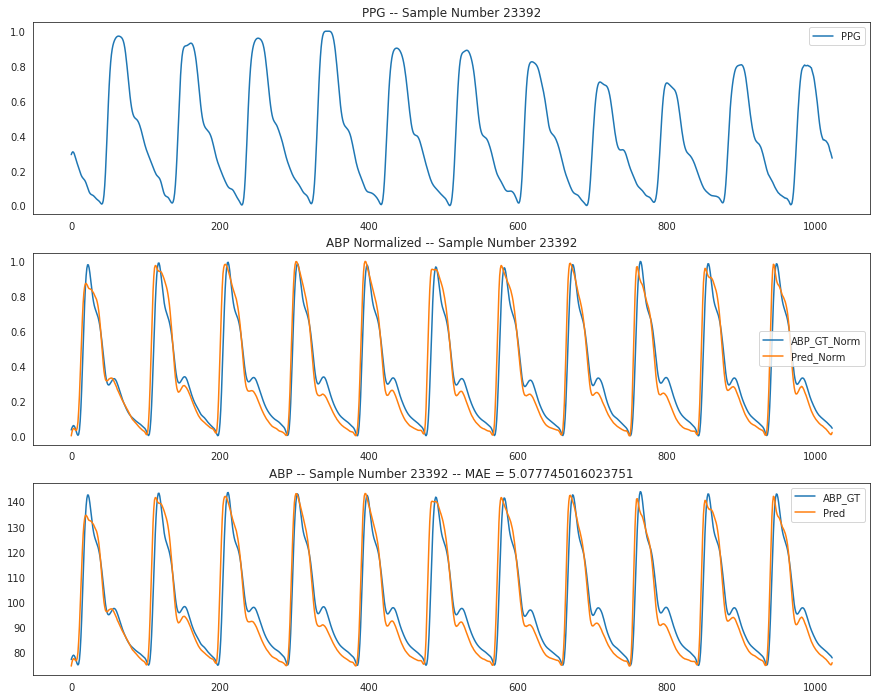

In [ ]:
i = random.randint(0,len(ABP_GRND))
MAE = np.mean(np.abs(ABP_App_Pred[i].ravel()-ABP_GRND[i].ravel()))
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.plot(X_Test1[i,:,0].ravel(), label='PPG');
plt.title(f"PPG -- Sample Number {i}")
plt.legend();
plt.subplot(3,1,2)
plt.plot(Y_Test2[i].ravel(), label='ABP_GT_Norm');
plt.plot(ABP_App[i].ravel(), label='Pred_Norm');
plt.title(f"ABP Normalized -- Sample Number {i}")
plt.legend();
plt.subplot(3,1,3)
plt.plot(ABP_GRND[i],label='ABP_GT');
plt.plot(ABP_App_Pred[i].ravel(), label='Pred');
plt.title(f"ABP -- Sample Number {i} -- MAE = {MAE}");
plt.legend();

Save Predicted ABP Waveforms

In [ ]:
hf = h5py.File('Results/ABP_Estimated_Fold_1.h5', 'w')
hf.create_dataset('ABP_RNorm', data=ABP_App)
hf.create_dataset('ABP', data=ABP_App_Pred)
hf.close()

## Evaluate ABP Estimation Performance

Construction Error

In [ ]:
[ABP_GRND_NEW, App_Predict_NEW] = Construction_Error_ABP(ABP_GRND, ABP_App_Pred)

Construction Error : 5.197 +/- 2.707
Number of Bad Predictions = 0


BHS Metric

------------------------------------------
|        BHS-Metric-ABP Estimation        |
------------------------------------------
------------------------------------------
|       | <= 5mmHg | <=10mmHg | <=15mmHg |
------------------------------------------
|  DBP  |   99.59 %   |   99.99 %   |  100.0 %    |
|  MAP  |   87.06 %   |   99.75 %   |  99.98 %    |
|  SBP  |   88.72 %   |   99.02 %   |  99.84 %    |
------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


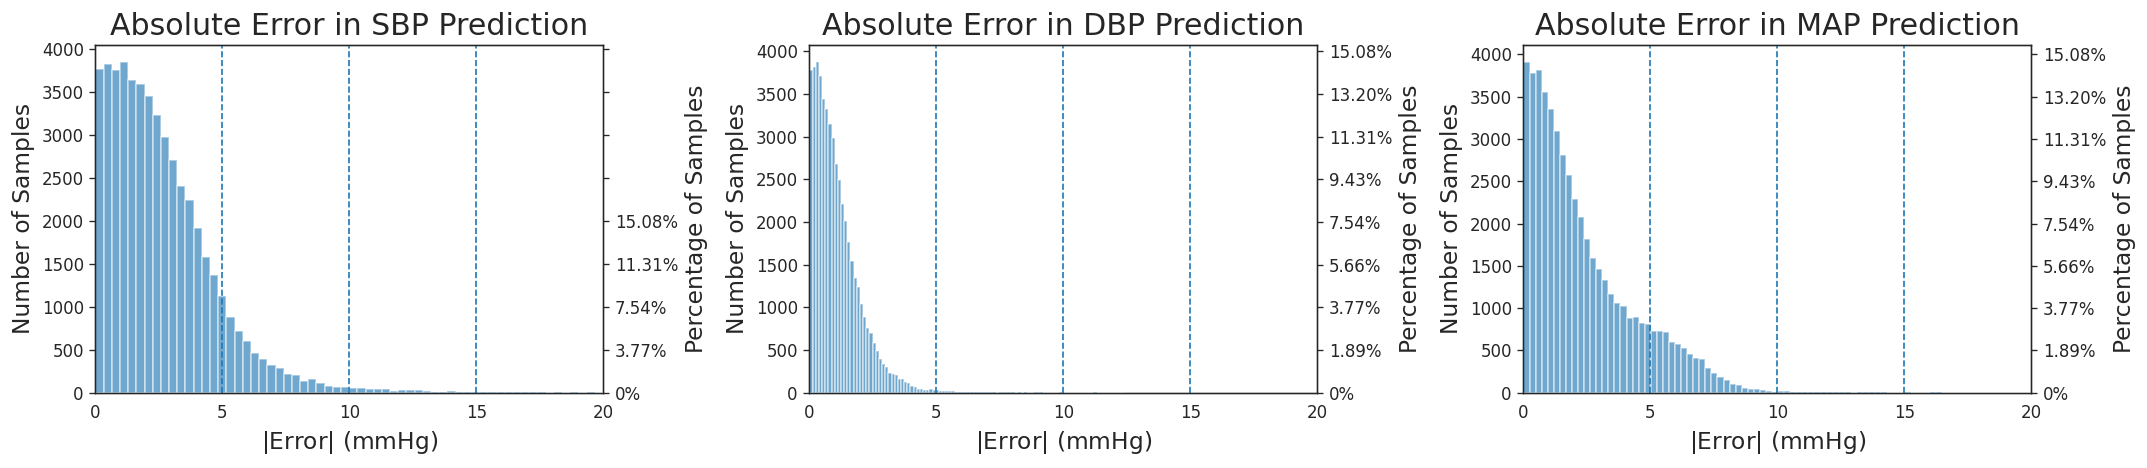

In [ ]:
BHS_Metric_ABP(ABP_GRND_NEW, App_Predict_NEW)

AAMI Standard

---------------------------------
|         AAMI Standard         |
---------------------------------
-----------------------
|     |   ME   |  STD  |
-----------------------
| DBP | -0.115 | 1.424 |
| MAP | -0.131 | 3.126 |
| SBP | 1.333 | 3.113 |
-----------------------


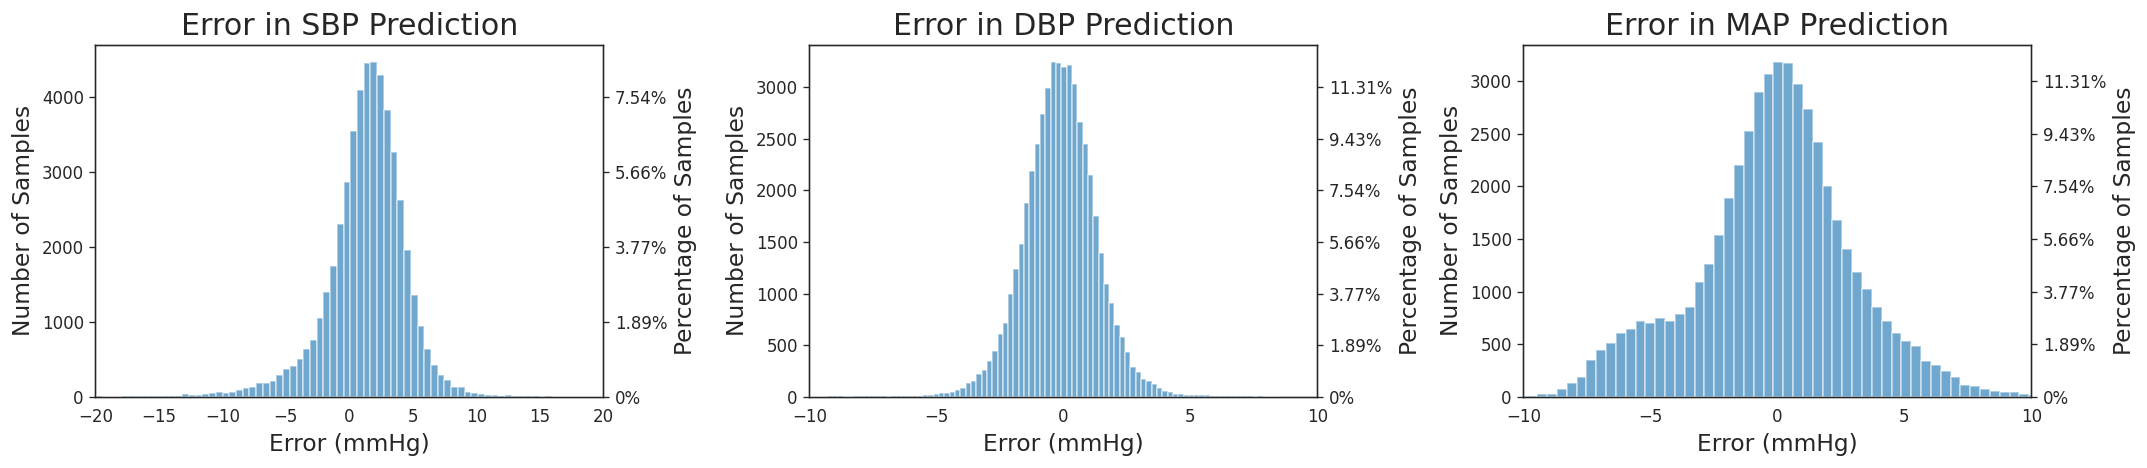

In [ ]:
calcErrorAAMI_ABP(ABP_GRND_NEW, App_Predict_NEW)

Evaluate Blood Pressure Level Classification from Estimated ABP Waveforms

DBP Classification Accuracy
                  precision    recall  f1-score   support

    Hypertension    0.97854   0.84784   0.90851      1183
    Normotension    0.98615   0.99689   0.99149     46287
Pre-hypertension    0.88551   0.78904   0.83450      3176

        accuracy                        0.98037     50646
       macro avg    0.95007   0.87793   0.91150     50646
    weighted avg    0.97966   0.98037   0.97971     50646

SBP Classification Accuracy
                 precision    recall  f1-score   support

   Hypertension    0.91901   0.96824   0.94298     18764
   Normotension    0.97246   0.88665   0.92757     14336
Prehypertension    0.87532   0.88829   0.88176     17546

       accuracy                        0.91745     50646
      macro avg    0.92227   0.91439   0.91744     50646
   weighted avg    0.91901   0.91745   0.91741     50646



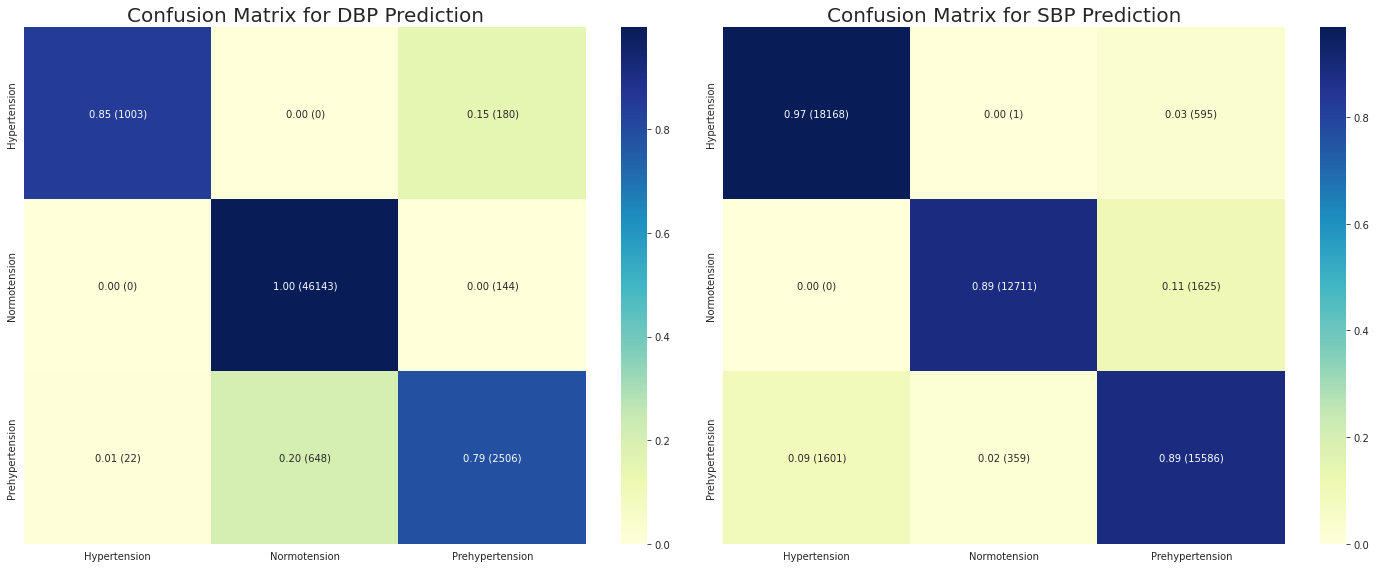

In [ ]:
evaluate_BP_Classification_ABP(ABP_GRND_NEW, App_Predict_NEW)

Regression Plots

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


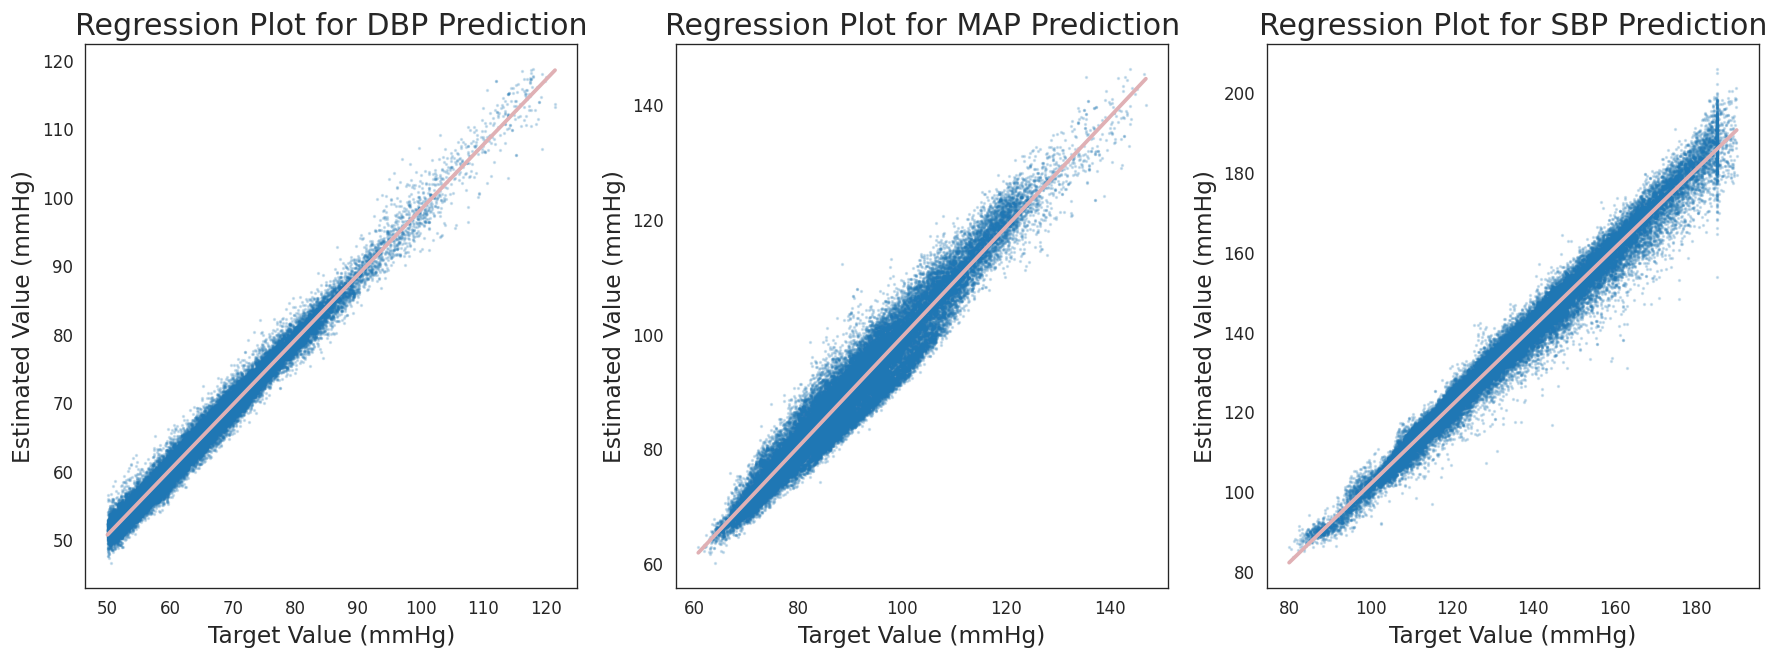

DBP
LinregressResult(slope=0.9492833278249674, intercept=3.1920203709431334, rvalue=0.991037442538495, pvalue=0.0, stderr=0.0005685877262696749, intercept_stderr=0.03753900240075264)
MAP
LinregressResult(slope=0.9582429818173422, intercept=3.622906373471892, rvalue=0.9716163874294621, pvalue=0.0, stderr=0.001036720916345509, intercept_stderr=0.09420392862815168)
SBP
LinregressResult(slope=0.9841594954930429, intercept=3.4633580085863684, rvalue=0.9895776513154988, pvalue=0.0, stderr=0.0006363775563835458, intercept_stderr=0.08667505930877138)


In [ ]:
regression_plot_ABP(ABP_GRND_NEW, App_Predict_NEW)

Bland-Altman Plots

---------DBP---------
2.9066184984638546 -2.676645320504971
---------MAP---------
6.258773295079264 -5.996265812468726
---------SBP---------
4.769057148478553 -7.435468722249651


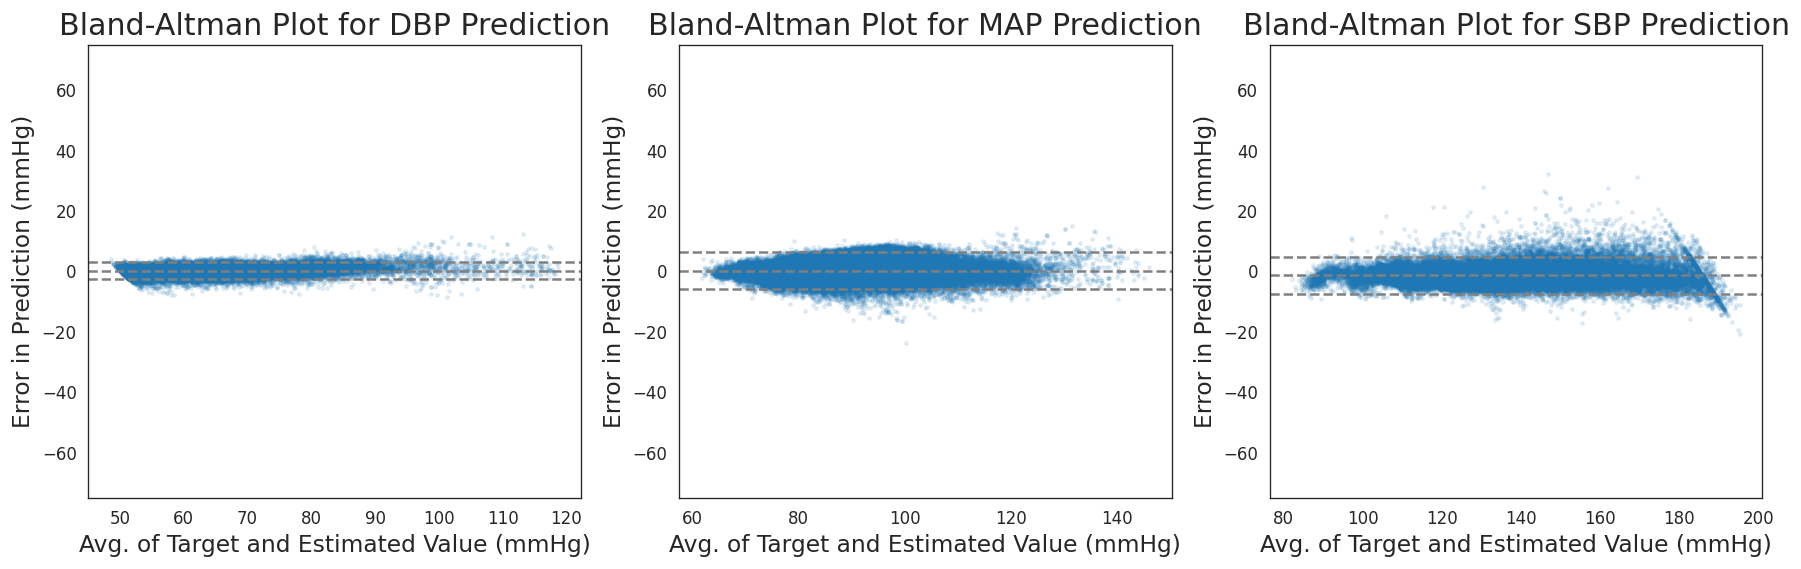

In [ ]:
bland_altman_plot_ABP(ABP_GRND_NEW, App_Predict_NEW)

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass